# **Research Notebook 03: Baseline Model (Logistic Regression with Hyperparameter Tuning)**

**Objective:** To build, train and evaluate our baseline model (Logistic Regression with TF-IDF) on the *Rigorously Cleaned* dataset to establish a true, non-leaky benchmark.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import time

In [2]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'
datasets_path = f'{base_path}datasets/'
models_path = f'{base_path}models/'

train_path = f'{datasets_path}train_dataset_clean.csv'
test_path = f'{datasets_path}test_dataset_clean.csv'
evaluation_path = f'{base_path}evaluation/'

model_save_path = f'{models_path}baseline_model_clean.pkl'

In [4]:
# Load Datasets

print("--- Baseline Model Development ---")

print("\nLoading datasets...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop any potential NaN rows
# We use the column we prepared for this model: 'cleaned_text_tfidf'
train_df = train_df.dropna(subset=['cleaned_text_tfidf'])
test_df = test_df.dropna(subset=['cleaned_text_tfidf'])

print(f"Training set loaded: {len(train_df)} articles")
print(f"Testing set loaded: {len(test_df)} articles")

--- Baseline Model Development ---

Loading datasets...
Training set loaded: 9024 articles
Testing set loaded: 2256 articles


In [5]:
# Prepare Data for Modeling

print("Prepare Data for Modeling...")

# X contains the features (our text)
# We use the 'cleaned_text_tfidf' column
X_train = train_df['cleaned_text_tfidf']
X_test = test_df['cleaned_text_tfidf']

# y contains the target labels
y_train = train_df['label']
y_test = test_df['label']

print("\nData prepared for modeling.")

Prepare Data for Modeling...

Data prepared for modeling.


In [6]:
# Create the Pipeline

print("Creating a machine learning pipeline...")
# A Pipeline chains our steps together.
# 1. 'tfidf': Run the TF-IDF Vectorizer
# 2. 'clf': Run the Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=101, solver='liblinear'))
])

print("\nCreated a machine learning piepline.")

Creating a machine learning pipeline...

Created a machine learning piepline.


In [7]:
# Define Parameter Grid for GridSearchCV

print("Defining the parameter grid for tuning...")

parameters = {
    'tfidf__max_features': [5000, 7500, 10000],  # Test 3 different vocab sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],   # Test single words vs. two-word phrases
    'clf__penalty': ['l1', 'l2'],             # Test L1 vs L2 penalty
    'clf__C': [0.1, 1.0, 10.0]                 # Test different regularization strengths
}

print("\nCreated parameter grid for tuning.")

Defining the parameter grid for tuning...

Created parameter grid for tuning.


In [8]:
# Run GridSearchCV

print("Starting GridSearchCV...")

# Define our Cross-Validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

start_time = time.time()
grid_search = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV finished in {(end_time - start_time):.2f} seconds.")

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GridSearchCV finished in 1217.56 seconds.


In [9]:
# Show Best Parameters

print("Analyzing tuning results...")
print(f"\nBest cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

Analyzing tuning results...

Best cross-validation score (Accuracy): 0.9726
Best parameters found:
{'clf__C': 10.0, 'clf__penalty': 'l2', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [10]:
# Evaluate the Best Model on the Test Set

print("Evaluating the best model on the unseen test set...")
y_pred = grid_search.predict(X_test)

# Create a new DataFrame to see the results
results_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred
})

# Print the first 10 results
print("\n--- Comparison of True vs. Predicted Labels ---\n")
results_df.head(10)

Evaluating the best model on the unseen test set...

--- Comparison of True vs. Predicted Labels ---



,text,true_label,predicted_label
0,joe piscopo is hysterical he was on with neil ...,fake,fake
1,democrats in congress ended a hour sit in on t...,real,real
2,a federal credit union has sued to block presi...,real,real
3,this announcement seems to indicate that the o...,fake,fake
4,president donald trump arrived in hawaii on fr...,real,real
5,u s attorney general jeff sessions stepped up ...,real,real
6,huma abedin is hillary s bad cop and is expose...,fake,fake
7,this woman has no shame muslim activist linda ...,fake,fake
8,maine governor paul lepage calls out a liberal...,fake,fake
9,donald trump s presidential campaign is buying...,real,real


In [11]:
# --- Key Performance Metrics ---

# We need probabilities for the ROC AUC score
# We also need to map our text labels to 0s and 1s for the ROC functions
y_test_numeric = y_test.map({'fake': 0, 'real': 1})
y_pred_probs = grid_search.predict_proba(X_test)[:, 1] # Probability of 'real'

# Calculate main scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc_score = roc_auc_score(y_test_numeric, y_pred_probs)

print(f"--- Final Model Accuracy:   {accuracy * 100:.2f}%")
print(f"--- Final Model Precision (Macro): {precision * 100:.2f}%")
print(f"--- Final Model Recall (Macro):    {recall * 100:.2f}%")
print(f"--- Final Model F1-Score (Macro):  {f1 * 100:.2f}%")
print(f"--- Final Model AUC Score:     {auc_score * 100:.2f}%")

--- Final Model Accuracy:   97.96%
--- Final Model Precision (Macro): 97.97%
--- Final Model Recall (Macro):    97.96%
--- Final Model F1-Score (Macro):  97.96%
--- Final Model AUC Score:     99.70%


In [12]:
# Save evaluation metrics as a table
baseline_metrics_df = pd.DataFrame([{
    "model": "baseline_model",
    "accuracy": accuracy,
    "precision_macro": precision,
    "recall_macro": recall,
    "f1_macro": f1,
    "auc": auc_score
}])

metrics_save_path = f'{evaluation_path}baseline_model_metrics.csv'
baseline_metrics_df.to_csv(metrics_save_path, index=False)

print(f"Baseline metrics saved to: {metrics_save_path}")


Baseline metrics saved to: /content/drive/MyDrive/Research/evaluation/baseline_model_metrics.csv


In [13]:
# Print the detailed classification report

print("--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['fake', 'real']))

--- Detailed Classification Report ---
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      1128
        real       0.97      0.99      0.98      1128

    accuracy                           0.98      2256
   macro avg       0.98      0.98      0.98      2256
weighted avg       0.98      0.98      0.98      2256



Generating Confusion Matrix...



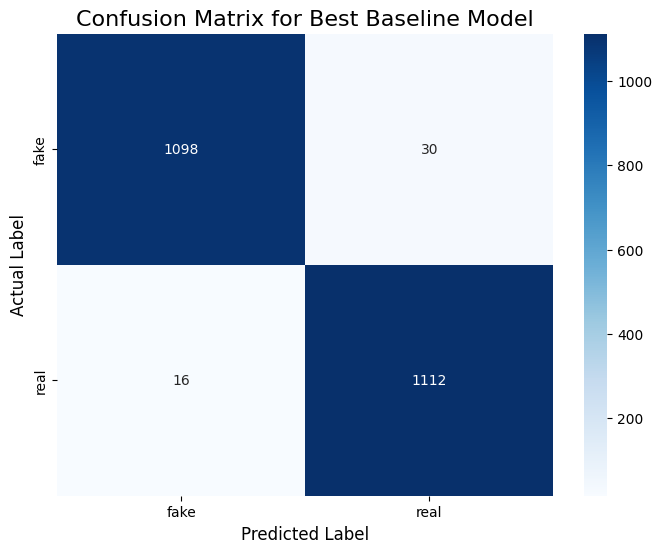


Confusion matrix saved to: /content/drive/MyDrive/Research/evaluation/baseline_model_confusion_matrix.png


In [14]:
# Visualize the Confusion Matrix

# Save Confusion Matrix
cm_save_path = f'{evaluation_path}baseline_model_confusion_matrix.png'

print("Generating Confusion Matrix...\n")
cm = confusion_matrix(y_test, y_pred)
labels = ['fake', 'real']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Best Baseline Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.savefig(cm_save_path, dpi=300)
plt.show()

print(f"\nConfusion matrix saved to: {cm_save_path}")

Generating ROC Curve...



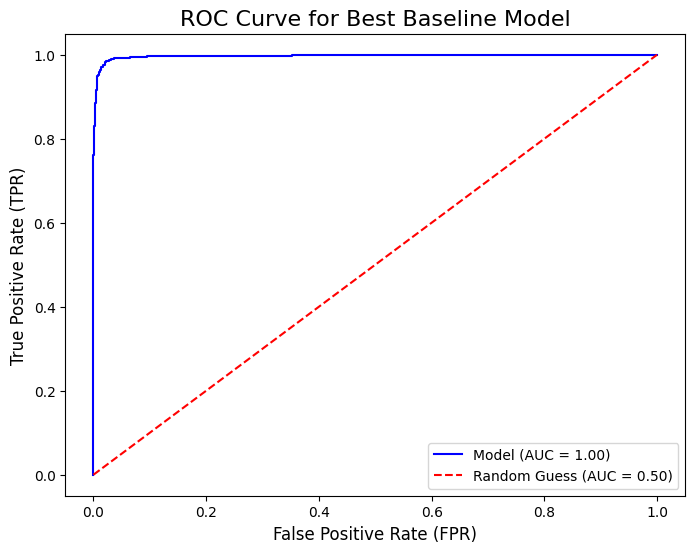

In [15]:
# Visualize the ROC AUC Curve

# Save ROC Curve
roc_save_path = f'{evaluation_path}baseline_model_roc_curve.png'

print("Generating ROC Curve...\n")
# Calculate the points for the curve
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_probs)

plt.figure(figsize=(8, 6))
# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f'Model (AUC = {auc_score:.2f})')
# Plot the "random guess" line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess (AUC = 0.50)')
plt.title('ROC Curve for Best Baseline Model', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend()
plt.show()

In [16]:
# Inspect Model Coefficients for Leakage

print("--- LEAKAGE CHECK (Inspect Top Features) ---")

# Get the best-performing pipeline
best_pipeline = grid_search.best_estimator_

# Get the two "tools" from the pipeline
tfidf_vectorizer = best_pipeline.named_steps['tfidf']
logistic_model = best_pipeline.named_steps['clf']

# Get the list of all words (features) the TF-IDF model learned
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the "importance" (coefficient) for each word
# The model has one set of coefficients, at index 0
coefficients = logistic_model.coef_[0]

# Check if the model mapped 'fake' to 0 and 'real' to 1
# We can get this from the model's 'classes_' attribute
if logistic_model.classes_[0] == 'fake' and logistic_model.classes_[1] == 'real':
    # 'real' is the positive class (class 1)
    # 'fake' is the negative class (class 0)

    # Zip words and their importances together
    feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: x[1])

    # Get the Top 20 "FAKE" words
    # (These will have the most negative coefficients)
    top_20_fake = feature_importance[:20]

    # Get the Top 20 "REAL" words
    # (These will have the most positive coefficients)
    top_20_real = feature_importance[-20:]

    print("\n--- TOP 20 'FAKE' NEWS INDICATORS (Negative Coefs) ---")
    for word, score in top_20_fake:
        print(f"{word}: {score:.4f}")

    print("\n--- TOP 20 'REAL' NEWS INDICATORS (Positive Coefs) ---")
    # We reverse the list to show highest-to-lowest
    for word, score in reversed(top_20_real):
        print(f"{word}: {score:.4f}")

else:
    print("\n[ERROR] Model class mapping is not 'fake'/'real'. Cannot determine feature importance.")

--- LEAKAGE CHECK (Inspect Top Features) ---

--- TOP 20 'FAKE' NEWS INDICATORS (Negative Coefs) ---
president trump: -9.4457
sen: -8.3123
gop: -7.5070
this: -7.2543
mr: -6.9462
hillary: -6.2772
just: -6.2347
us: -6.2105
rep: -5.7077
is: -5.6866
com: -5.1975
you: -5.0105
watch: -4.6615
the us: -4.6091
didn: -4.5572
entire: -4.3826
president obama: -4.3212
pic: -4.2753
twitter com: -4.2643
here: -4.2378

--- TOP 20 'REAL' NEWS INDICATORS (Positive Coefs) ---
said: 16.8833
said on: 10.3926
on: 9.5737
reuters: 8.7880
president donald: 8.4169
republican: 8.3797
on wednesday: 7.8835
on tuesday: 7.5112
on thursday: 7.0450
edt: 6.9444
on friday: 6.8300
on monday: 5.7381
said in: 5.6552
in: 5.4710
democratic: 4.9860
president barack: 4.7332
in statement: 4.6705
nov: 4.6212
told reporters: 4.4150
senate: 4.3174


In [17]:
# Save the Best Model

print("Saving the best trained model pipeline...")
# The 'grid_search.best_estimator_' is our final, trained pipeline
joblib.dump(grid_search.best_estimator_, model_save_path)
print(f"Model saved to: {model_save_path}")

print("\n--- Baseline Model Development Complete ---")

Saving the best trained model pipeline...
Model saved to: /content/drive/MyDrive/Research/models/baseline_model_clean.pkl

--- Baseline Model Development Complete ---
